<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2010%20-CNN%20Applications%20and%20Tricks/Exercicio_Simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Simpsons classification

In [6]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics

#To ensure reproducibility
#we set the random seed
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

In [12]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):

      x = x.numpy()
      x = np.squeeze(x)
      y = y.numpy()
      plot_sidebsyide(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [7]:
!wget https://github.com/andrehochuli/teaching/raw/main/datasets/Simpsons.zip -O Simpsons.zip

--2023-10-23 21:31:48--  https://github.com/andrehochuli/teaching/raw/main/datasets/Simpsons.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrehochuli/teaching/main/datasets/Simpsons.zip [following]
--2023-10-23 21:31:48--  https://raw.githubusercontent.com/andrehochuli/teaching/main/datasets/Simpsons.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14750621 (14M) [application/zip]
Saving to: ‘Simpsons.zip’

Simpsons.zip        100%[===================>]  14.07M  --.-KB/s    in 0.1s    

2023-10-23 21:31:49 (113 MB/s) - ‘Simpsons.zip’ saved [14750621/14750621]



In [10]:
!unzip -qo Simpsons.zip

In [40]:
data_dir = './Simpsons/Treino'
batch_size_ = 32
input_shape_ = (96,96,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 253 files belonging to 6 classes.
Using 203 files for training.
Found 253 files belonging to 6 classes.
Using 50 files for validation.


['bart', 'family', 'homer', 'lisa', 'maggie', 'marge']
tf.Tensor([0 5 1 0 4 0 2 0 2 0 2 2 0 0 2 2 0 3 5 3 0 0 2 2 2 1 3 3 4 5 3 0], shape=(32,), dtype=int32)


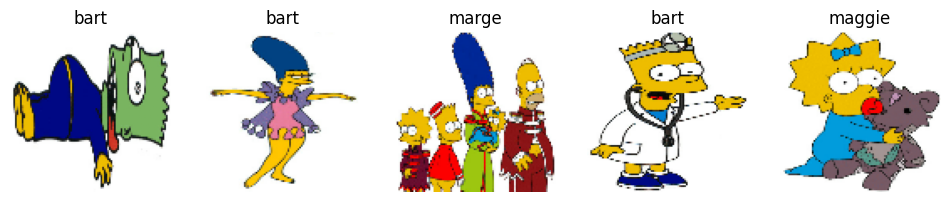

tf.Tensor([0 4 4 5 0 3 2 1 1 2 0 3 2 4 0 3 5 0 0 2 5 0 2 2 2 5 0 1 3 0 1 1], shape=(32,), dtype=int32)


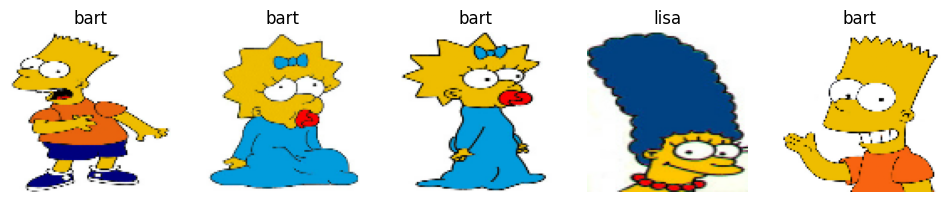

tf.Tensor([2 0 3 0 0 0 4 0 2 5 0 1 0 2 3 2 0 0 4 5 5 4 4 0 1 2 3 0 4 0 5 4], shape=(32,), dtype=int32)


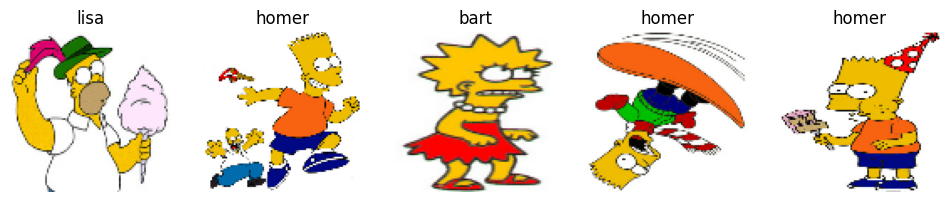

tf.Tensor([2 4 0 1 0 3 3 2 2 5 0 2 2 2 0 0 0 3 5 1 0 3 1 4 2 1 3 3 4 4 2 1], shape=(32,), dtype=int32)


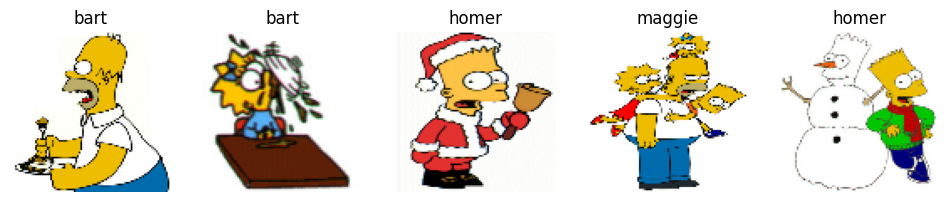

tf.Tensor([0 4 4 4 0 2 5 4 4 2 3 5 1 4 2 3 3 0 0 0 2 1 2 0 0 2 0 2 0 5 0 3], shape=(32,), dtype=int32)


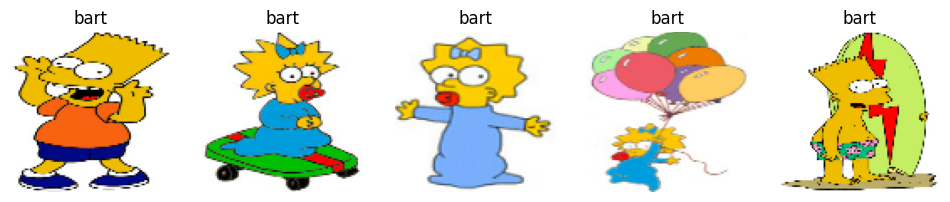

In [39]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(5):

  titles = []
  print(lbl)
  for i in lbl:
    titles.append(class_names[lbl[i]])

  plot_sidebyside(img[:5]/255.,titles[:5])

In [41]:
y_train = []
x_train = []
#test_ds = test_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

for img, labels in train_ds:
    y_train.extend(labels.numpy())
    x_train.extend(img)

y_train = np.array(y_train)
x_train = np.array(x_train)

In [42]:
ret = np.unique(y_train,return_counts=True)
print(class_names)
print(ret)

['bart' 'family' 'homer' 'lisa' 'maggie' 'marge']
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([61, 22, 46, 30, 25, 19]))


In [43]:
model = models.Sequential()

#Feature Learning (Convolutions)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))
######################################

# Fully-Connect (Classifcation)
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))



model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 10, 10, 128)      

In [44]:
epochs_ = 10
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 7s 714ms/step - loss: 5.8988 - acc: 0.1823 - val_loss: 1.7100 - val_acc: 0.3200
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 1.8042 - acc: 0.2463 - val_loss: 1.6557 - val_acc: 0.3000
Epoch 3/10
7/7 [==============================] - 4s 491ms/step - loss: 1.6893 - acc: 0.2611 - val_loss: 1.6281 - val_acc: 0.3200
Epoch 4/10
7/7 [==============================] - 3s 455ms/step - loss: 1.6530 - acc: 0.3005 - val_loss: 1.5495 - val_acc: 0.4000
Epoch 5/10
7/7 [==============================] - 5s 682ms/step - loss: 1.5752 - acc: 0.3645 - val_loss: 1.4764 - val_acc: 0.4400
Epoch 6/10
7/7 [==============================] - 4s 480ms/step - loss: 1.4290 - acc: 0.3941 - val_loss: 1.2878 - val_acc: 0.5000
Epoch 7/10
7/7 [==============================] - 4s 481ms/step - loss: 1.4489 - acc: 0.3990 - val_loss: 1.3226 - val_acc: 0.5000
Epoch 8/10
7/7 [==============================] - 5s 694ms/step - loss: 1.3824 - acc: 0.4286 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


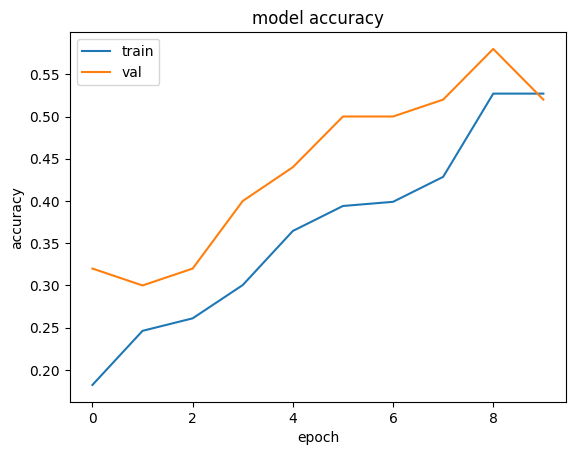

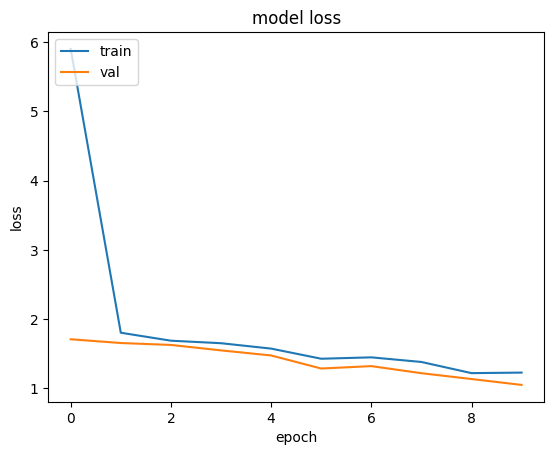

In [46]:
plot_history(history)

In [47]:
model = models.Sequential()

#Feature Learning (Convolutions)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))

######################################

# Fully-Connect (Classifcation)
model.add(layers.Dropout(0.10))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 43, 43, 128)       73856     
                                                                 
 conv2d_38 (Conv2D)          (None, 41, 41, 64)        73792     
                                                                 
 conv2d_39 (Conv2D)          (None, 39, 39, 32)        18464     
                                                      

In [48]:
epochs_ = 10
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Epoch 1/10


Exception ignored in: <function _xla_gc_callback at 0x793ebce65990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


7/7 [==============================] - 77s 2s/step - loss: 239.9795 - acc: 0.1823 - val_loss: 3.4486 - val_acc: 0.1400
Epoch 2/10
7/7 [==============================] - 19s 3s/step - loss: 3.0095 - acc: 0.1921 - val_loss: 1.8049 - val_acc: 0.0200
Epoch 3/10
7/7 [==============================] - 18s 2s/step - loss: 1.7862 - acc: 0.2660 - val_loss: 1.8156 - val_acc: 0.2800
Epoch 4/10
7/7 [==============================] - 18s 3s/step - loss: 1.7892 - acc: 0.2956 - val_loss: 1.8083 - val_acc: 0.2800
Epoch 5/10
7/7 [==============================] - 17s 2s/step - loss: 1.7867 - acc: 0.2956 - val_loss: 1.8007 - val_acc: 0.2800
Epoch 6/10
7/7 [==============================] - 15s 2s/step - loss: 1.7830 - acc: 0.3005 - val_loss: 1.7963 - val_acc: 0.2800
Epoch 7/10
7/7 [==============================] - 16s 2s/step - loss: 1.7794 - acc: 0.3005 - val_loss: 1.7940 - val_acc: 0.2800
Epoch 8/10
7/7 [==============================] - 17s 2s/step - loss: 1.7737 - acc: 0.3103 - val_loss: 1.7952 - v

#Data Augmentation

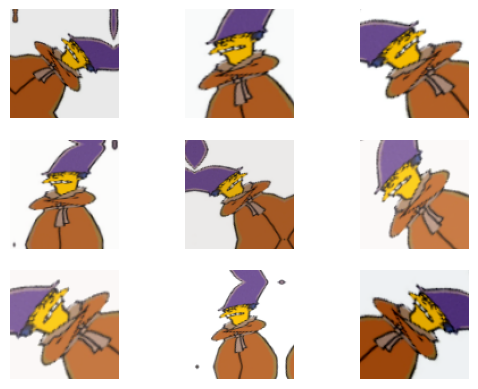

In [53]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(input_shape_[0],
                                  input_shape_[1],
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.3),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
  ]
)

for images, _ in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [55]:
model = tf.keras.Sequential([
  data_augmentation, #Data Augmentation
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.Dropout(0.1), #Regularization
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 48, 48, 128)       73856     
                                                     

In [56]:
epochs_ = 10
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 18s 2s/step - loss: 2.0677 - acc: 0.1921 - val_loss: 1.7470 - val_acc: 0.3400
Epoch 2/10
7/7 [==============================] - 13s 2s/step - loss: 1.7313 - acc: 0.3005 - val_loss: 1.6372 - val_acc: 0.3400
Epoch 3/10
7/7 [==============================] - 13s 2s/step - loss: 1.7056 - acc: 0.2512 - val_loss: 1.5822 - val_acc: 0.3400
Epoch 4/10
7/7 [==============================] - 13s 2s/step - loss: 1.5820 - acc: 0.3399 - val_loss: 1.4533 - val_acc: 0.4000
Epoch 5/10
7/7 [==============================] - 13s 2s/step - loss: 1.3834 - acc: 0.3990 - val_loss: 1.0837 - val_acc: 0.6200
Epoch 6/10
7/7 [==============================] - 13s 2s/step - loss: 1.3614 - acc: 0.4778 - val_loss: 1.2336 - val_acc: 0.4800
Epoch 7/10
7/7 [==============================] - 15s 2s/step - loss: 1.2496 - acc: 0.4975 - val_loss: 1.2979 - val_acc: 0.4400
Epoch 8/10
7/7 [==============================] - 17s 2s/step - loss: 1.2003 - acc: 0.4877 - val_loss: 1

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


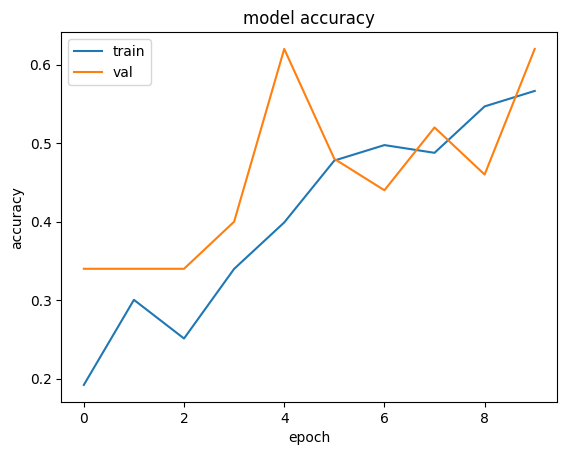

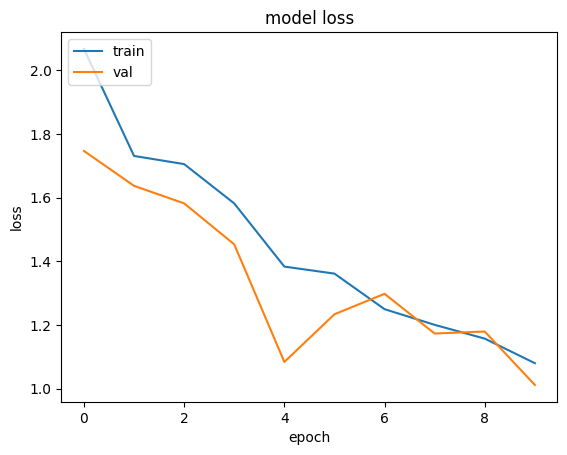

In [57]:
plot_history(history)

#Transfer Learning

In [58]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                        input_tensor=tf.keras.layers.Input(input_shape_),
                                                      classes=num_classes)
conv_layers.trainable = False


conv_layers.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [59]:
model = tf.keras.Sequential([
  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

epochs_ = 50
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_27 (Dense)            (None, 256)               524544    
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                     

In [61]:
model = tf.keras.Sequential([
  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='my_model/model_checkpoint.h5',  # Specify the file to save the weights
    save_best_only=True,             # Save only the best model
    monitor='val_acc' ,              # Monitoring validation loss
    mode='max',
    verbose=1
)

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback])


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_33 (Dense)            (None, 256)               524544    
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                     

Exception ignored in: <function _xla_gc_callback at 0x793ebce65990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


7/7 [==============================] - ETA: 0s - loss: 2.0501 - acc: 0.3202
Epoch 1: val_acc improved from -inf to 0.34000, saving model to my_model/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 71s 2s/step - loss: 2.0501 - acc: 0.3202 - val_loss: 1.5283 - val_acc: 0.3400
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.9688 - acc: 0.6305
Epoch 2: val_acc improved from 0.34000 to 0.44000, saving model to my_model/model_checkpoint.h5
7/7 [==============================] - 12s 2s/step - loss: 0.9688 - acc: 0.6305 - val_loss: 1.3771 - val_acc: 0.4400
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.6640 - acc: 0.7537
Epoch 3: val_acc improved from 0.44000 to 0.58000, saving model to my_model/model_checkpoint.h5
7/7 [==============================] - 11s 2s/step - loss: 0.6640 - acc: 0.7537 - val_loss: 1.3849 - val_acc: 0.5800
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.4417 - acc: 0.8522
Epoch 4: val_acc did not improve from 0.58000
7/7 [==============================] - 10s 1s/step - loss: 0.4417 - acc: 0.8522 - val_loss: 1.2076 - val_acc: 0.5800
Epoch 5/20
7/7 [=================

In [62]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  f'./Simpsons/Teste/',
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 106 files belonging to 6 classes.


In [63]:
model.evaluate(test_ds)

4/4 [==============================] - 6s 1s/step - loss: 1.9339 - acc: 0.6415


[1.9338523149490356, 0.6415094137191772]

In [64]:
loaded_model = tf.keras.models.load_model('my_model/model_checkpoint.h5')
loaded_model.evaluate(test_ds)

4/4 [==============================] - 4s 700ms/step - loss: 1.8551 - acc: 0.6226


[1.8550846576690674, 0.6226415038108826]

#Transfer Leaning => Fine Tunning das ultimas 2 camadas de convolução!

In [77]:
conv_layers.trainable=True

n_layers = len(conv_layers.layers)
print(n_layers)
for j in range(0,n_layers-7):
    conv_layers.layers[j].trainable = False



for j in range(n_layers-7,n_layers):
    conv_layers.layers[j].trainable = True

conv_layers.summary()
#base_model.layers[j].trainable = True

175
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                   

In [ ]:
model = tf.keras.Sequential([
  conv_layers,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.3),

  layers.Flatten(),
  #layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='my_model/model_checkpoint.h5',  # Specify the file to save the weights
    save_best_only=True,             # Save only the best model
    monitor='val_acc' ,              # Monitoring validation loss
    mode='max',
    verbose=1
)

epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=batch_size_, epochs=epochs_, validation_data=val_ds, callbacks=[checkpoint_callback])


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                                 
 dense_46 (Dense)            (None, 256)               524544    
                                                                 
 dense_47 (Dense)            (None, 128)               32896     
                                                     